In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Imports

In [2]:
# local 
from funcdataset import *
import models

# pyTorch
from torch.utils.data import DataLoader

# fastai
from fastai.basic_data import DataBunch
import fastai.basic_train as basic_train
import fastai.metrics as metrics
import fastai.callbacks as callbacks
import fastai

# custom fastai additions
from fastai_additions import *

# Settings

In [3]:
# data settings
training_data = 'data/eNose-base-dataset'  # string or list of strings
normalise_data = True
balance_datasets=True
merge_eth_ipa_ac = True

In [4]:
# model settings
model_type = 'multi_layer_perceptron'
n_hidden_layers = 3


In [5]:
# training settings
max_epochs = 100
batch_size = 16

useMultiLabelClassification = True
saveResults = True

# Load data

In [6]:
# load dataset
dataset = FuncDataset(data_dir=training_data, convertToRelativeVectors=True,
                      calculateFuncVectors=True, convertToMultiLabels=useMultiLabelClassification)

if merge_eth_ipa_ac:
    dataset.rename_class("Aceton", "Eth IPA Ac")
    dataset.rename_class("Ethanol", "Eth IPA Ac")
    dataset.rename_class("Isopropanol", "Eth IPA Ac")

# split into train & validate set based on dir name
dataset.setDirSplit(["train"], ["validate"], normaliseData=normalise_data, balanceDatasets=balance_datasets)



Loading data/eNose-base-dataset/train/1_Ethanol_200206.csv
Loading data/eNose-base-dataset/train/1_Ethanol_200207.csv
Loading data/eNose-base-dataset/train/1_Ethanol_200210.csv
Loading data/eNose-base-dataset/train/1_Ethanol_200211.csv
Loading data/eNose-base-dataset/train/1_Ethanol_200212.csv
Loading data/eNose-base-dataset/train/1_Ethanol_200214.csv
Loading data/eNose-base-dataset/train/1_Ethanol_200218.csv
Loading data/eNose-base-dataset/train/1_Ethanol_200221.csv
Loading data/eNose-base-dataset/train/1_Ethanol_200224.csv
Loading data/eNose-base-dataset/train/2_Isopropanol_200206.csv
Loading data/eNose-base-dataset/train/2_Isopropanol_200207.csv
Loading data/eNose-base-dataset/train/2_Isopropanol_200210.csv
Loading data/eNose-base-dataset/train/2_Isopropanol_200211.csv
Loading data/eNose-base-dataset/train/2_Isopropanol_200212.csv
Loading data/eNose-base-dataset/train/2_Isopropanol_200214.csv
Loading data/eNose-base-dataset/train/2_Isopropanol_200218.csv
Loading data/eNose-base-data

Loading data/eNose-base-dataset/validate/ipa_1mL_200219.csv
Loading data/eNose-base-dataset/validate/ipa_2_200203.csv
Loading data/eNose-base-dataset/validate/ipa_3_200203.csv
Loading data/eNose-base-dataset/validate/ipa_4_200203.csv
Loading data/eNose-base-dataset/validate/toluol_1_200203.csv
Loading data/eNose-base-dataset/validate/toluol_2_200203.csv
Loading data/eNose-base-dataset/validate/toluol_3_200203.csv
Loading data/eNose-base-dataset/validate/toluol_4_200203.csv


# Prepare fastai train loop

In [11]:
# get model name
if saveResults:
    train_name = input()
    load_name = train_name

test


In [12]:
# create fastai databunch
train_dataLoader = DataLoader(dataset, batch_size=batch_size, num_workers=8, shuffle=True)
valid_dataLoader = DataLoader(dataset.get_eval_dataset(), batch_size=batch_size, num_workers=8, shuffle=True)
data = DataBunch(train_dataLoader, valid_dataLoader)

# create model
model = models.create_model(model_type, dataset, nHiddenLayers=n_hidden_layers, loss_func=dataset.loss_func)

In [13]:
# create fastai Learner:
# prepare metrics
class MultiLabelFbeta05Macro(metrics.MultiLabelFbeta): pass
class MultiLabelFbeta10Micro(metrics.MultiLabelFbeta): pass
class MultiLabelFbeta10Macro(metrics.MultiLabelFbeta): pass
class MultiLabelFbeta20Macro(metrics.MultiLabelFbeta): pass
class MultiLabelFbeta40Macro(metrics.MultiLabelFbeta): pass


f1_micro_score = MultiLabelFbeta10Micro(beta=1.0, thresh=0.3, average='micro')
f1_macro_score = MultiLabelFbeta10Macro(beta=1.0, thresh=0.3, average='macro')
f05_macro_score = MultiLabelFbeta05Macro(beta=0.5, thresh=0.3, average='macro')
f2_macro_score = MultiLabelFbeta20Macro(beta=2.0, thresh=0.3, average='macro')
f4_macro_score = MultiLabelFbeta40Macro(beta=4.0, thresh=0.3, average='macro')

precision = MultiLabelPrecision(thresh=0.3, average='micro')
recall = MultiLabelRecall(thresh=0.3, average='micro')

exact_match_score = MultiLabelExactMatch()

metric_list = [
    exact_match_score,
    precision,
    recall,
    f4_macro_score
]

# create Learner
learn = basic_train.Learner(data, model, metrics=metric_list, loss_func=dataset.loss_func, callback_fns=ShowGraph)

# add additional callbacks
extra_callbacks = [
    callbacks.EarlyStoppingCallback(learn, min_delta=1e-5, patience=10)
    # callbacks.SaveModelCallback(learn)
]

learn.callbacks += extra_callbacks

if saveResults:
    save_callbacks = [
        callbacks.SaveModelCallback(learn, name=train_name, monitor='multi_label_fbeta40_macro'),
        callbacks.CSVLogger(learn, 'models/' + train_name)
    ]

    learn.callbacks += save_callbacks

# Train model

epoch,train_loss,valid_loss,multi_label_exact_match,multi_label_precision,multi_label_recall,multi_label_fbeta40_macro,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


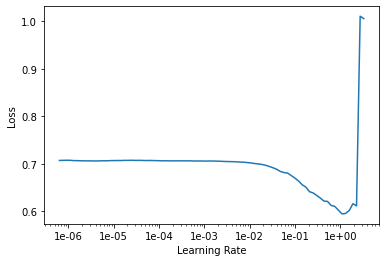

In [43]:
learn.lr_find(wd=0.)
learn.recorder.plot()

epoch,train_loss,valid_loss,multi_label_exact_match,multi_label_precision,multi_label_recall,multi_label_fbeta40_macro,time
0,0.369461,0.475894,0.491284,0.470247,0.513471,0.489475,00:04
1,0.330004,0.459901,0.407686,0.514545,0.448494,0.453267,00:04
2,0.319582,0.451374,0.459984,0.467018,0.654517,0.635715,00:04
3,0.299734,0.455735,0.430269,0.469611,0.657158,0.639638,00:04
4,0.252665,0.417035,0.481775,0.542914,0.718436,0.705470,00:04
5,0.233421,0.414209,0.531696,0.572844,0.824617,0.802497,00:04
6,0.209561,0.427235,0.602219,0.613488,0.696778,0.691095,00:04
7,0.181075,0.416277,0.639065,0.625628,0.789223,0.774965,00:04
8,0.169653,0.392942,0.652139,0.651624,0.816165,0.803578,00:03
9,0.156922,0.397519,0.639857,0.646259,0.802958,0.791721,00:04


Better model found at epoch 0 with multi_label_fbeta40_macro value: 0.48947471380233765.


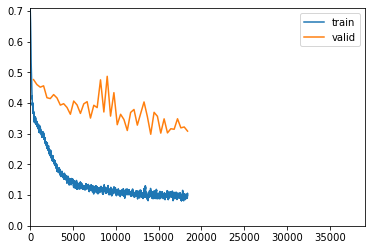

Better model found at epoch 2 with multi_label_fbeta40_macro value: 0.6357145309448242.
Better model found at epoch 3 with multi_label_fbeta40_macro value: 0.63963782787323.
Better model found at epoch 4 with multi_label_fbeta40_macro value: 0.705470085144043.
Better model found at epoch 5 with multi_label_fbeta40_macro value: 0.8024969100952148.
Better model found at epoch 8 with multi_label_fbeta40_macro value: 0.8035775423049927.
Better model found at epoch 11 with multi_label_fbeta40_macro value: 0.8214354515075684.
Better model found at epoch 17 with multi_label_fbeta40_macro value: 0.8296374082565308.
Better model found at epoch 25 with multi_label_fbeta40_macro value: 0.8406479358673096.
Better model found at epoch 28 with multi_label_fbeta40_macro value: 0.8782433271408081.
Epoch 46: early stopping


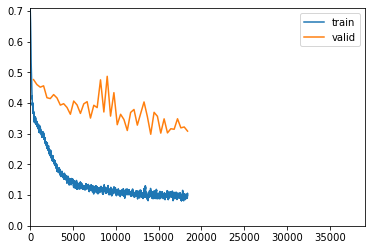

In [44]:
learn.fit(max_epochs, wd=0.)

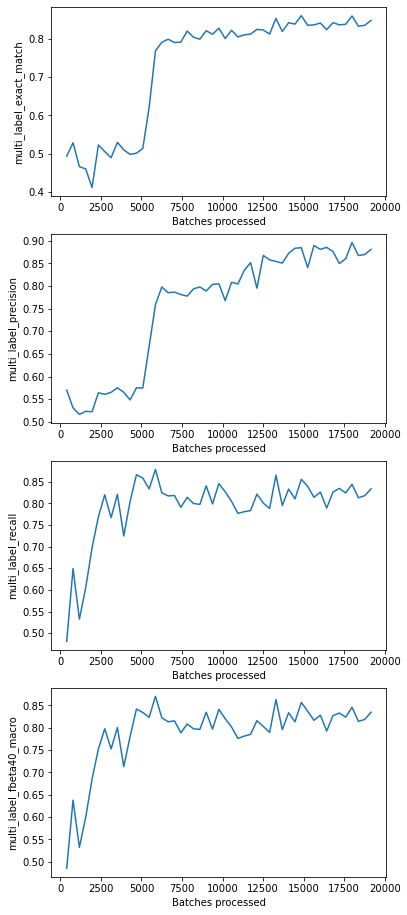

In [36]:
learn.recorder.plot_metrics()

# Analyse results

In [14]:
load_name = input()

mergedPerc3_wd01


In [15]:
learn = learn.load(load_name)

In [26]:
preds,y,losses = learn.get_preds(with_loss=True)

print(preds[0])
print(losses[0])
print (y[0])

tensor([1.1188e-05, 3.0822e-01, 9.0508e-01])
tensor([1.1206e-05, 3.6849e-01, 9.9730e-02])
tensor([0., 0., 1.])


In [27]:
learn.predict(ItemBase(torch.tensor([0., 1., 2., 3., 4., 5., 6., 7.])))

AttributeError: 'FuncDataset' object has no attribute 'set_item'

In [ ]:
interp = MultiLabelClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix()

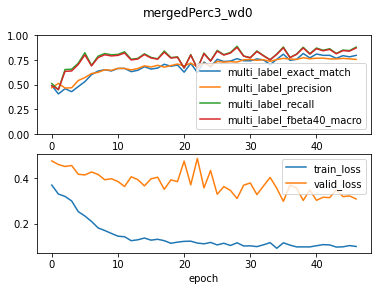

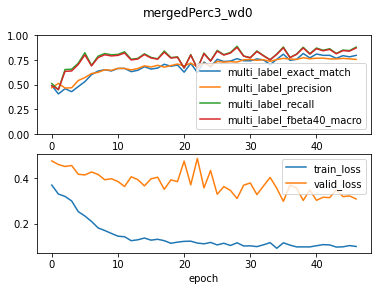

In [54]:
ta = TrainAnalyser(load_name)
ta.plot_metrics()